# DTSA 5510 Unsupervised Algorithms in ML Final Project: Leveraging Hierarchical Clustering to Predict Customer Targeting Opportunities in E-commerce

### Step 1: Gather data, determine the method of data collection and provenace of the data [3 points]
The data I will be using comes from an online dataset published on Kaggle. The dataset is a tabular form of data consist of information of online transactions with 25900 entries and 8 columns.

Data source: https://www.kaggle.com/datasets/thedevastator/online-retail-transaction-data

### Step 2: Identify an Unsupervised Learning Problem [6 points]
The objective of this project is to ascertain which customer cohorts exhibit a higher likelihood of purchase. To accomplish this, a hierarchical clustering model will be developed for data exploration and customer segmentation. Additionally, a K-means clustering method will be employed to construct a separate model for comparative analysis.

### Step 3: Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data [26 points]

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
retail = pd.read_csv('data/online_retail_data.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Verify if there is null values and drop them

In [5]:
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Droping rows having missing values

In [6]:
retail = retail.dropna()
retail.shape

(406829, 8)

Exploring features for customers

In [7]:
customer_ids = retail["CustomerID"].nunique()
customer_ids

4372

Exploring features for stock codes

In [8]:
stockcodes = retail["StockCode"].nunique()
stockcodes

3684

Exploring features for quality

<Axes: ylabel='Quantity'>

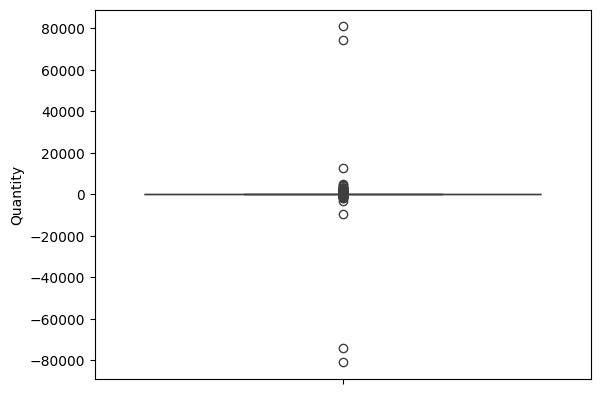

In [9]:
sns.boxplot(retail["Quantity"])

From the quality boxplot, it looks like there are quite some outliers, and some negative values for the quantity; the next step will be to remove those values. 

In [10]:
retail = retail[retail['Quantity'] >= 0]
retail.shape

(397924, 8)

After dropping those values, eliminate the outliers.

In [11]:
quantity = retail["Quantity"]

Q1 = np.percentile(quantity, 25)
Q3 = np.percentile(quantity, 75)

IQR = Q3 - Q1

upper_whisker = Q3 + 1.5 * IQR

print("Upper whisker:", upper_whisker)

Upper whisker: 27.0


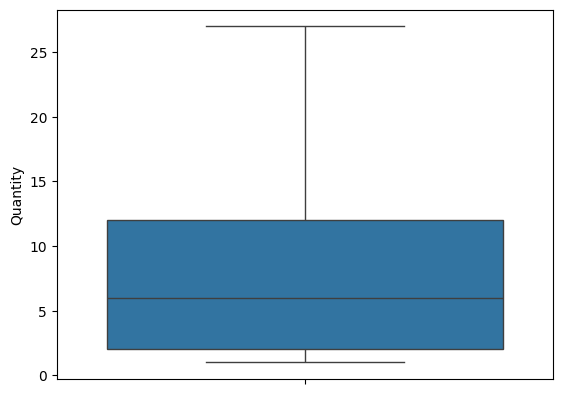

In [12]:
retail.loc[retail["Quantity"] > 27, "Quantity"] = 27
sns.boxplot(retail["Quantity"])
plt.show()

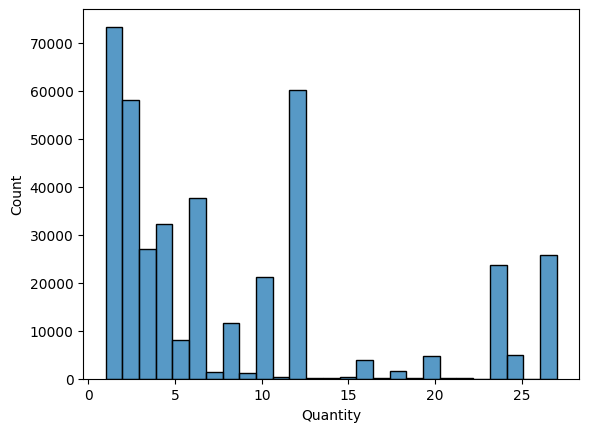

In [13]:
sns.histplot(retail["Quantity"] , bins = 27)
plt.show()

### Step 4: Analysis Using Unsupervised Learning Models, Present Discussion, and Conclusions [70 points]

In [14]:
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,28.08
1,12347.0,3973.79
2,12348.0,850.07
3,12349.0,1735.05
4,12350.0,334.40


In [15]:
rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [16]:
rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,28.08,1
1,12347.0,3973.79,182
2,12348.0,850.07,31
3,12349.0,1735.05,73
4,12350.0,334.40,17


In [17]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [18]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [19]:
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [20]:
rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:49:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [21]:
rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [22]:
rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,28.08,1,325
1,12347.0,3973.79,182,1
2,12348.0,850.07,31,74
3,12349.0,1735.05,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

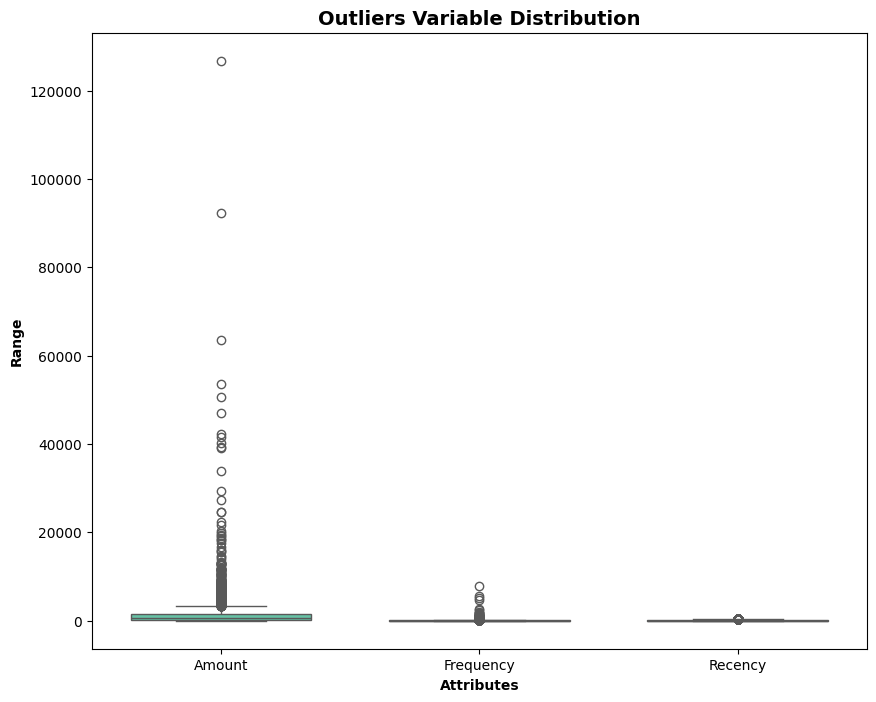

In [23]:
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [24]:
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [25]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4277, 3)

In [26]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.728238,-0.771867,2.318406
1,1.760418,1.080408,-0.914920
2,-0.209789,-0.464860,-0.186424
3,0.348390,-0.035051,-0.745270
4,-0.535035,-0.608130,2.158736


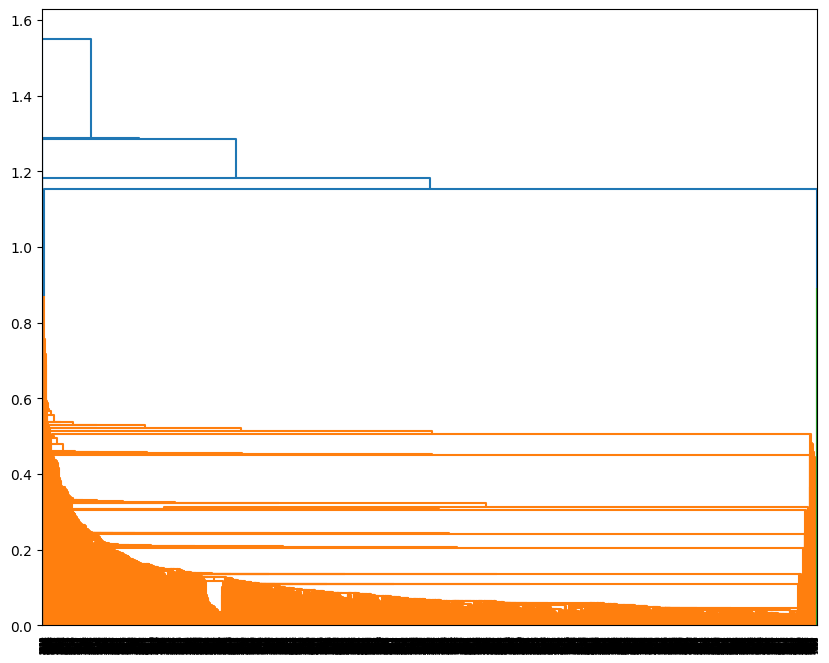

In [27]:
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

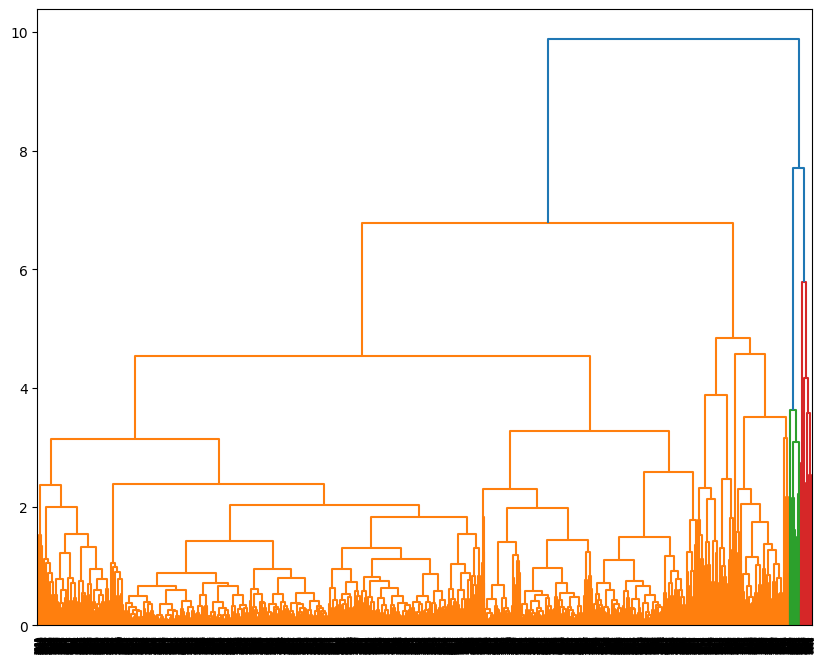

In [28]:
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [29]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
rfm['Cluster_Labels'] = cluster_labels
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Labels
0,12346.0,28.08,1,325,0
1,12347.0,3973.79,182,1,0
2,12348.0,850.07,31,74,0
3,12349.0,1735.05,73,18,0
4,12350.0,334.40,17,309,0


<Axes: xlabel='Cluster_Labels', ylabel='Amount'>

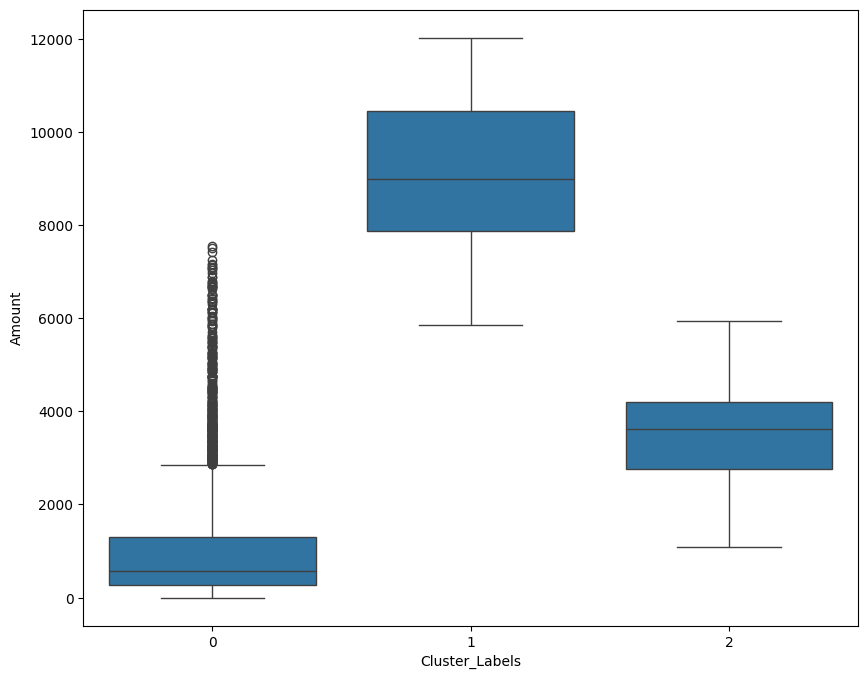

In [31]:
sns.boxplot(x='Cluster_Labels', y='Amount', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Frequency'>

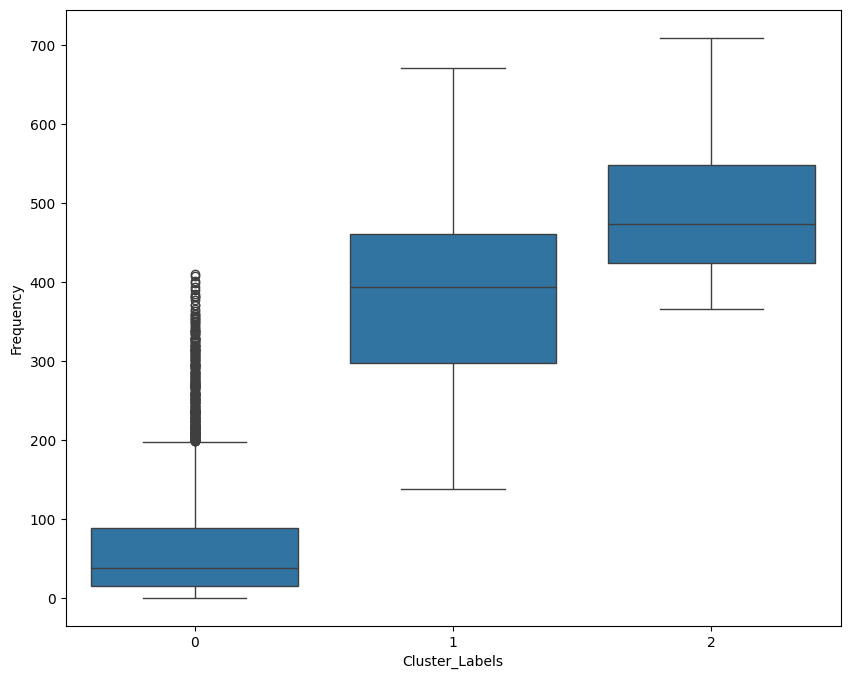

In [32]:
sns.boxplot(x='Cluster_Labels', y='Frequency', data=rfm)

<Axes: xlabel='Cluster_Labels', ylabel='Recency'>

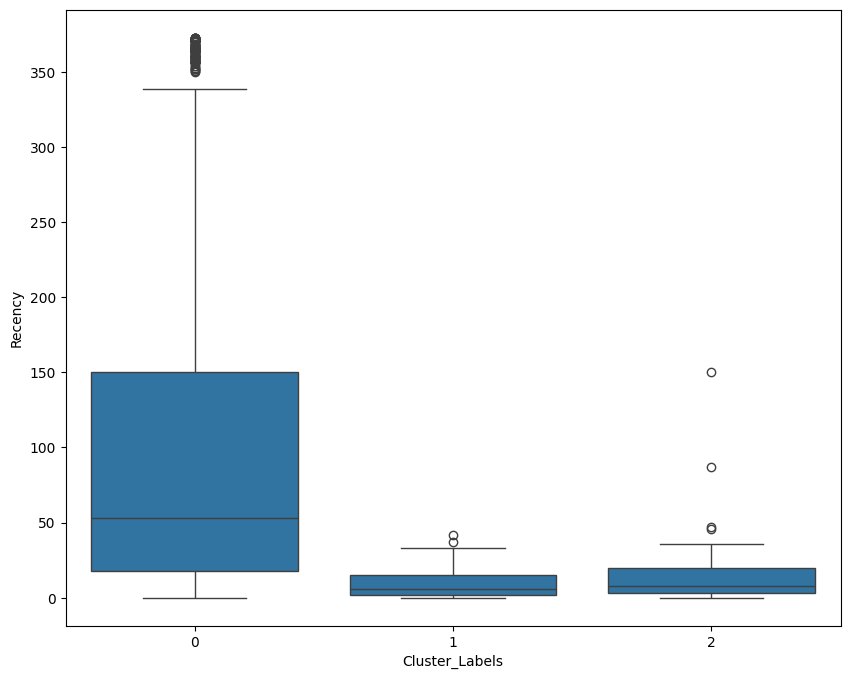

In [33]:
sns.boxplot(x='Cluster_Labels', y='Recency', data=rfm)

[1 0 1 ... 1 1 1]


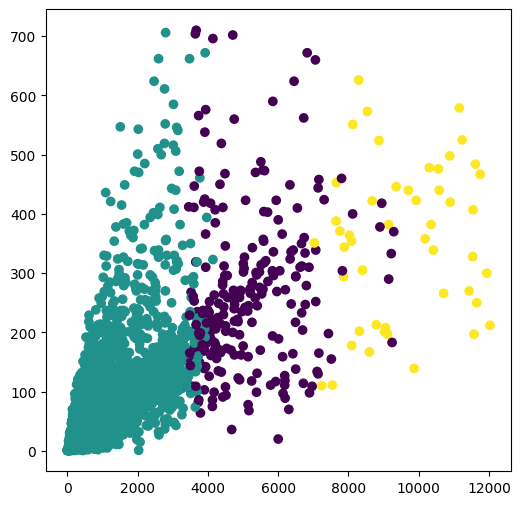

In [34]:
model_3 = AgglomerativeClustering(n_clusters = 3, linkage='complete').fit(rfm)
print(model_3.labels_)

plt.figure(figsize =(6, 6)) 
plt.scatter(rfm['Amount'], rfm['Frequency'],  
           c = model_3.fit_predict(rfm), label = model_3.labels_) 

Build Model

In [35]:
model_5 = AgglomerativeClustering(n_clusters = 5, linkage='complete').fit(rfm)
print(model_5.labels_) 

[2 3 2 ... 4 4 4]


Visualizing the clustering 

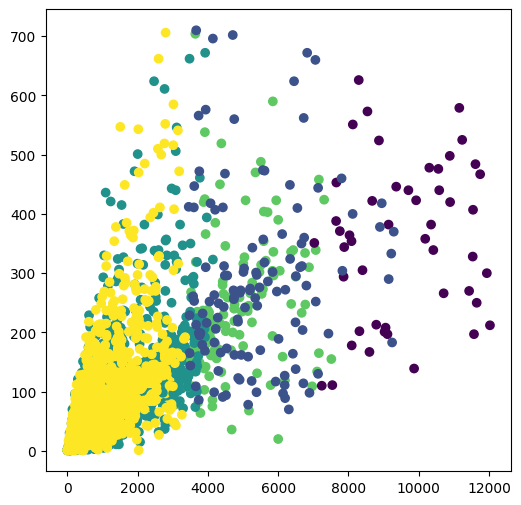

In [36]:
plt.figure(figsize =(6, 6)) 
plt.scatter(rfm['Amount'], rfm['Frequency'],  
           c = model_5.fit_predict(rfm), label = model_5.labels_) 
plt.show()

In [37]:
k = [2, 3, 4, 5, 6, 7, 8, 9] 
model_2 = AgglomerativeClustering(n_clusters = 2, linkage='complete').fit(rfm)
model_4 = AgglomerativeClustering(n_clusters = 4, linkage='complete').fit(rfm)
model_6 = AgglomerativeClustering(n_clusters = 6, linkage='complete').fit(rfm)
model_7 = AgglomerativeClustering(n_clusters = 7, linkage='complete').fit(rfm)
model_8 = AgglomerativeClustering(n_clusters = 8, linkage='complete').fit(rfm)
model_9 = AgglomerativeClustering(n_clusters = 9, linkage='complete').fit(rfm)

silhouette_scores = [] 
silhouette_scores.append( 
        silhouette_score(rfm, model_2.fit_predict(rfm))) 
silhouette_scores.append( 
        silhouette_score(rfm, model_3.fit_predict(rfm))) 
silhouette_scores.append( 
        silhouette_score(rfm, model_4.fit_predict(rfm))) 
silhouette_scores.append( 
        silhouette_score(rfm, model_5.fit_predict(rfm))) 
silhouette_scores.append( 
        silhouette_score(rfm, model_6.fit_predict(rfm))) 
silhouette_scores.append( 
        silhouette_score(rfm, model_7.fit_predict(rfm))) 
silhouette_scores.append( 
        silhouette_score(rfm, model_8.fit_predict(rfm))) 
silhouette_scores.append( 
        silhouette_score(rfm, model_9.fit_predict(rfm))) 

Plotting a bar graph to compare the results 

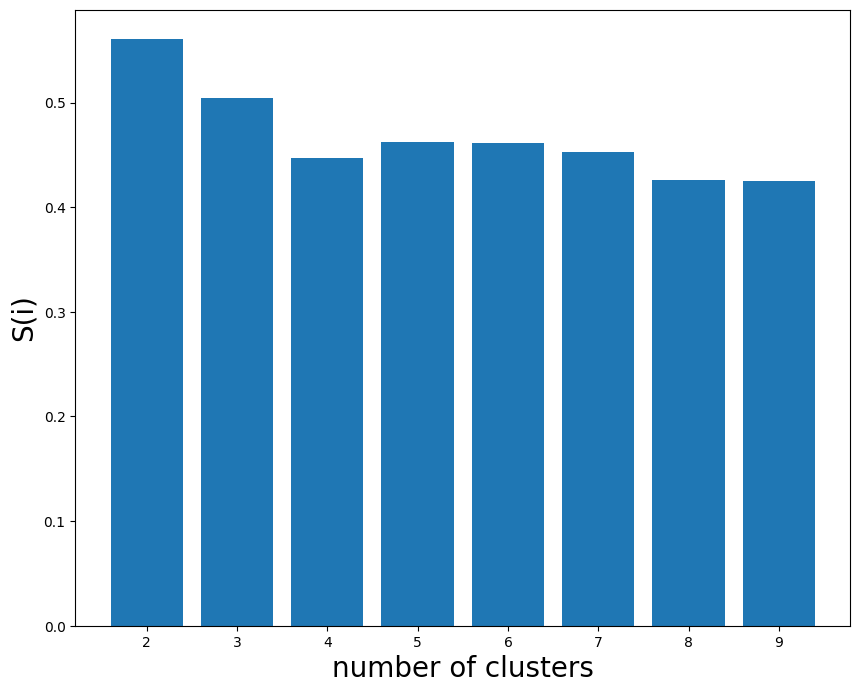

In [38]:
plt.bar(k, silhouette_scores) 
plt.xlabel('number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 

[1 0 1 ... 1 1 1]


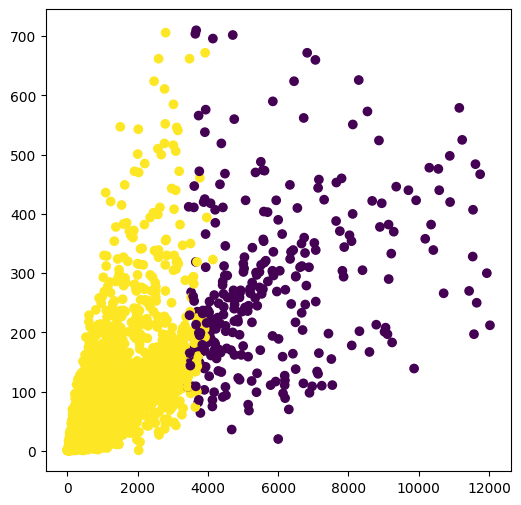

In [39]:
model = AgglomerativeClustering(n_clusters = 2, linkage='complete').fit(rfm)
print(model.labels_)

plt.figure(figsize =(6, 6)) 
plt.scatter(rfm['Amount'], rfm['Frequency'],  
           c = model.fit_predict(rfm), label = model.labels_) 
plt.show() 

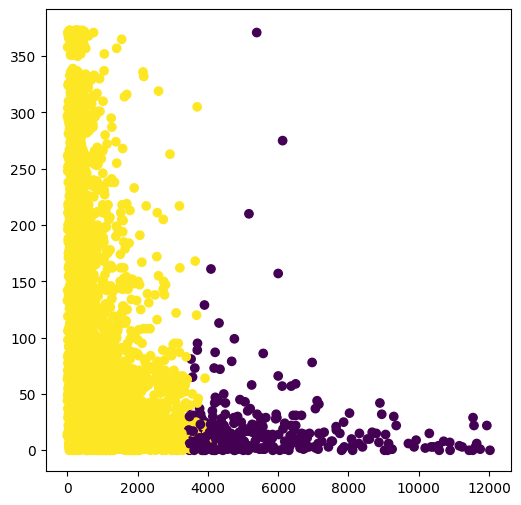

In [40]:
plt.figure(figsize =(6, 6)) 
plt.scatter(rfm['Amount'], rfm['Recency'],  
           c = model.fit_predict(rfm), label = model.labels_) 
plt.show() 

### K Means Clstering

In [41]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [42]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

Find the optimal number of clusters using Elbow-curve/SSD

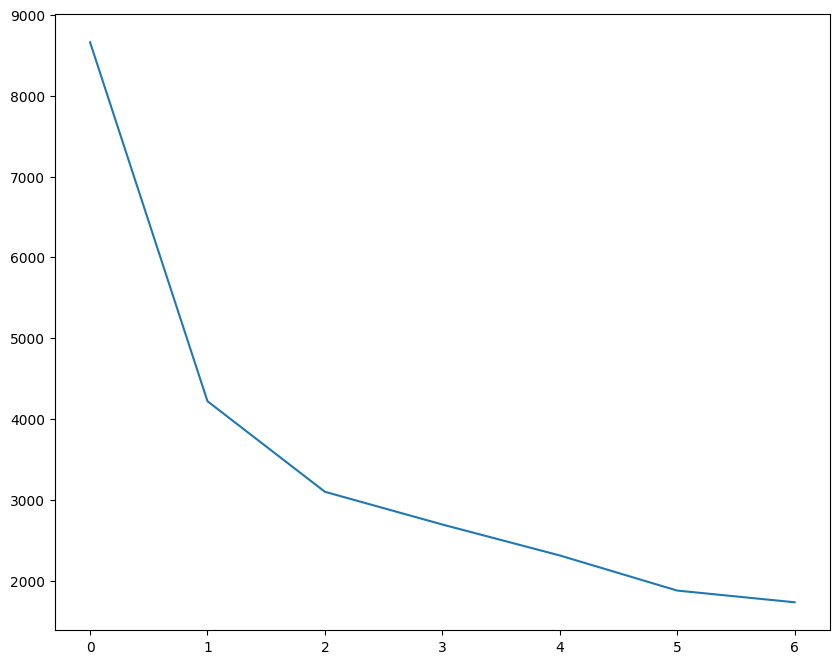

In [43]:
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)

### Discussion and Conclusion
Both hierarchical clustering (using the AgglomerativeClustering module) and K-means clustering (using the K-means module) analyses indicate that dividing the dataset into two clusters yields the most effective modeling results. This suggests that users can be distinctly categorized into two groups. This two-cluster model can then be used to predict the purchasing likelihood for each group, specifically in terms of the amount, frequency, and recency of their purchases.

The dataset also contains a column detailing the specific items purchased, which is recognized as potentially more valuable for future analysis and prediction. However, due to time constraints and the need for expertise in natural language processing (NLP) and data grouping, leveraging this detailed item description data is deferred for future exploration. The current focus remains on the insights derived from the two-cluster model based on purchasing behaviors.